# 1. Import the libraries 

In [1]:
#import the reqired libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

# 2. Load the dataset

In [2]:
# Import the dataset
df = pd.read_csv('collaborative.csv')
print(df.shape)

(1000000, 4)


In [3]:
df.head()

,Unnamed: 0,user-id,product-id,reviews
0,0,0,36250,1
1,1,0,33831,4
2,2,0,12799,2
3,3,0,33431,5
4,4,0,18536,1


#### Dropping the Unnamed: 0 column

In [4]:
df.drop('Unnamed: 0',axis=1,inplace=True)
print(df.shape)

(1000000, 3)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype
---  ------      --------------    -----
 0   user-id     1000000 non-null  int64
 1   product-id  1000000 non-null  int64
 2   reviews     1000000 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB


In [6]:
#Check the number of rows and columns
rows,columns=df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  1000000
Number of columns:  3


In [7]:
#Check the datatypes
df.dtypes

user-id       int64
product-id    int64
reviews       int64
dtype: object

In [8]:
#Summary statistics of rating variable
df['reviews'].describe().transpose()

count    1000000.000000
mean           3.665633
std            1.490878
min            1.000000
25%            2.000000
50%            4.000000
75%            5.000000
max            5.000000
Name: reviews, dtype: float64

In [9]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(df.reviews.min()))
print('Maximum rating is: %d' %(df.reviews.max()))

Minimum rating is: 1
Maximum rating is: 5


* Rating are on the scale 1 to 5.

# Handling Missing values

In [10]:
#Check for missing values
print('Number of missing values across columns: \n',df.isnull().sum())

Number of missing values across columns: 
 user-id       0
product-id    0
reviews       0
dtype: int64


* There are no missing records in the dataset.

## Ratings

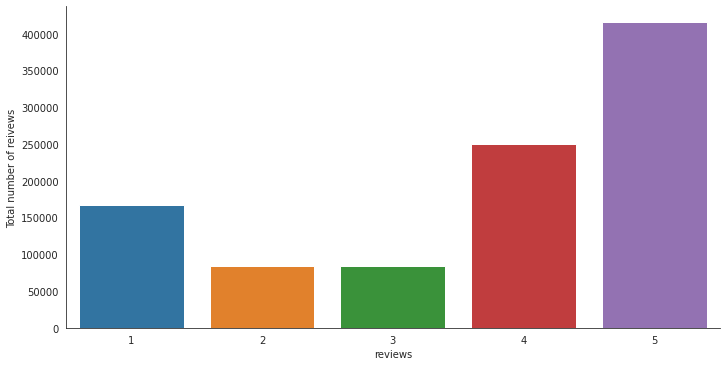

In [11]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("reviews", data=df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of reivews") 

* We can see that more number of users have given the rating of 5.

## Users and products

In [12]:
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', df['user-id'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', df['product-id'].nunique())

Number of unique users in Raw data =  5001
Number of unique product in Raw data =  44424


# 3. Taking the subset of dataset to make it less sparse/ denser.

In [13]:
#Check the top 10 users based on ratings
most_rated=df.groupby('user-id').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 user-id
2597    258
1814    255
580     253
234     251
3422    251
742     247
3486    246
3868    246
686     246
4639    243
dtype: int64


In [14]:
counts=df['user-id'].value_counts()
df_final=df[df['user-id'].isin(counts[counts>=15].index)]
print('Number of users who have rated 25 or more items =', len(df_final))
print('Number of unique users in the final data = ', df_final['user-id'].nunique())
print('Number of unique products in the final data = ', df_final['product-id'].nunique())

Number of users who have rated 25 or more items = 1000000
Number of unique users in the final data =  5001
Number of unique products in the final data =  44424


* df_final has the users who have rated 25 or more items.

## ratings analysis in final dataset

In [15]:
#constructing the pivot table
final_ratings_matrix = df_final.pivot(index = 'user-id', columns ='product-id', values = 'reviews').fillna(0)
final_ratings_matrix.head()

product-id,1163,1164,1165,1525,1526,1528,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1561,1562,1563,...,59951,59961,59962,59963,59964,59965,59966,59967,59968,59969,59970,59971,59972,59973,59974,59975,59976,59977,59978,59979,59980,59981,59982,59983,59984,59985,59986,59987,59988,59989,59990,59991,59992,59993,59994,59995,59996,59998,59999,60000
user-id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* It shows that it is a sparse matrix. So, many cells are filled with 0 values.

In [16]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (5001, 44424)


* We can see that there are 44424 products and 5001 users.

In [17]:
#Calucating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  1000000
possible_num_of_ratings =  222164424
density: 0.45%


* The density value of the matrix also shows that it is a sparse matrix.

# 4. Splitting the data

In [18]:
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(df_final, test_size = 0.3, random_state=0)
train_data.head()

,user-id,product-id,reviews
823666,4118,33155,5
70066,352,46839,5
591943,2963,46293,1
578645,2896,8612,5
675461,3379,42804,1


In [19]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (700000, 3)
Shape of testing data:  (300000, 3)


# 5. Building Popularity Recommender model

In [20]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('product-id').agg({'user-id': 'count'}).reset_index()
train_data_grouped.rename(columns = {'user-id': 'score'},inplace=True)
train_data_grouped.head(40)

,product-id,score
0,1163,8
1,1164,13
2,1165,19
3,1525,19
4,1526,9
5,1528,10
6,1529,19
7,1530,14
8,1531,11
9,1532,11


In [21]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'product-id'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,product-id,score,rank
15615,20046,35,1.0
7597,10564,33,2.0
28330,37344,33,3.0
15255,19647,32,4.0
30779,40749,32,5.0


In [22]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['user-id'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [23]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

The list of recommendations for the userId: 10

       user-id  product-id  score  rank
15615       10       20046     35   1.0
7597        10       10564     33   2.0
28330       10       37344     33   3.0
15255       10       19647     32   4.0
30779       10       40749     32   5.0


The list of recommendations for the userId: 100

       user-id  product-id  score  rank
15615      100       20046     35   1.0
7597       100       10564     33   2.0
28330      100       37344     33   3.0
15255      100       19647     32   4.0
30779      100       40749     32   5.0


The list of recommendations for the userId: 150

       user-id  product-id  score  rank
15615      150       20046     35   1.0
7597       150       10564     33   2.0
28330      150       37344     33   3.0
15255      150       19647     32   4.0
30779      150       40749     32   5.0




* Since, it is a Popularity recommender model, so, all the three users are given the same recommendations. Here, we predict the products based on the popularity. It is not personalized to particular user. It is a non-personalized recommender system.

# 6. Building Collaborative Filtering recommender model.

In [24]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.head()

,index,user-id,product-id,reviews
0,823666,4118,33155,5
1,70066,352,46839,5
2,591943,2963,46293,1
3,578645,2896,8612,5
4,675461,3379,42804,1


## User Based Collaborative Filtering model

In [25]:
# Matrix with row per 'user' and column per 'item' 
pivot_df = df_CF.pivot(index = 'user-id', columns ='product-id', values = 'reviews').fillna(0)
pivot_df.head()

product-id,1163,1164,1165,1525,1526,1528,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1561,1562,1563,...,59951,59961,59962,59963,59964,59965,59966,59967,59968,59969,59970,59971,59972,59973,59974,59975,59976,59977,59978,59979,59980,59981,59982,59983,59984,59985,59986,59987,59988,59989,59990,59991,59992,59993,59994,59995,59996,59998,59999,60000
user-id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (5001, 44424)


In [27]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

product-id,1163,1164,1165,1525,1526,1528,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1561,1562,1563,...,59961,59962,59963,59964,59965,59966,59967,59968,59969,59970,59971,59972,59973,59974,59975,59976,59977,59978,59979,59980,59981,59982,59983,59984,59985,59986,59987,59988,59989,59990,59991,59992,59993,59994,59995,59996,59998,59999,60000,user_index
user-id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [28]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

product-id,1163,1164,1165,1525,1526,1528,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1561,1562,1563,...,59951,59961,59962,59963,59964,59965,59966,59967,59968,59969,59970,59971,59972,59973,59974,59975,59976,59977,59978,59979,59980,59981,59982,59983,59984,59985,59986,59987,59988,59989,59990,59991,59992,59993,59994,59995,59996,59998,59999,60000
user_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* As this is a sparse matrix we will use SVD.

### Singular Value Decomposition

In [29]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)

In [30]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[-0.01384159  0.06745486  0.00424561 ...  0.03013169  0.01090254
  -0.01664181]
 [-0.00596262  0.00079281  0.00635326 ... -0.00610051  0.00091896
  -0.01311313]
 [ 0.01695084 -0.00817492  0.04965002 ...  0.01150083  0.01362015
  -0.01473207]
 ...
 [ 0.01650944 -0.01725929 -0.0039299  ...  0.01225143  0.00314817
  -0.0144938 ]
 [ 0.00624203 -0.0018889  -0.02066474 ... -0.01972667 -0.04402828
  -0.01656409]
 [ 0.0123787   0.00271687  0.00236943 ...  0.00154919 -0.00495563
  -0.01300628]]


In [31]:
print('Sigma: \n',sigma)

Sigma: 
 [ 74.90962739  74.92747857  74.97559005  75.06194712  75.09535655
  75.15749236  75.22385701  75.29729004  75.37009439 252.98133032]


* As sigma is not a diagonal matrix we have to convert it into diagonal matrix.

In [32]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[ 74.90962739   0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.          74.92747857   0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.          74.97559005   0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.          75.06194712   0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.          75.09535655
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
   75.15749236   0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.          75.22385701   0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.      

In [33]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[-0.00029506  0.00298607 -0.00784074 ...  0.0022173  -0.00154869
   0.01378408]
 [-0.0012417  -0.0033092   0.00257619 ... -0.00306135 -0.01061056
   0.01408908]
 [ 0.00890914  0.0097526   0.00443921 ... -0.00047694  0.00052661
   0.00568996]
 ...
 [ 0.0008639   0.00151711 -0.00185423 ... -0.00289292  0.00636531
   0.00909746]
 [-0.00124703 -0.0042374  -0.00824249 ...  0.00398968  0.00612632
   0.00165827]
 [-0.00291877 -0.00452402 -0.00588894 ... -0.0046548  -0.00549004
  -0.00580688]]


In [34]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

product-id,1163,1164,1165,1525,1526,1528,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1561,1562,1563,...,59951,59961,59962,59963,59964,59965,59966,59967,59968,59969,59970,59971,59972,59973,59974,59975,59976,59977,59978,59979,59980,59981,59982,59983,59984,59985,59986,59987,59988,59989,59990,59991,59992,59993,59994,59995,59996,59998,59999,60000
0,0.002369,0.000180,0.050286,0.037185,-0.018834,-0.004535,0.028688,-0.010551,0.013437,0.053942,0.020748,-0.049536,0.004105,-0.021160,-0.021033,-0.014436,0.025514,0.022986,0.012743,0.029707,0.034004,-0.012778,0.023451,-0.001840,0.001610,0.009537,0.014855,0.055277,0.040869,-0.010183,-0.034467,0.019943,0.029986,-0.022212,-0.018957,-0.009120,-0.003152,0.029346,-0.038313,-0.016431,...,0.009638,-0.049497,-0.043975,0.017242,0.031279,0.005005,0.048305,-0.009220,0.030176,0.010279,-0.084676,0.042558,0.034881,0.028607,0.003541,-0.036927,0.048679,0.061390,0.037294,-0.024805,0.039828,0.041058,0.047740,-0.000723,0.043330,0.000559,0.038940,-0.006329,0.020722,-0.005335,0.038070,-0.019708,0.005537,0.021396,-0.025644,0.060163,0.035595,0.016137,-0.027196,0.091866
1,0.013201,0.021952,0.027619,0.011277,0.007179,0.017955,0.017721,0.024650,0.006553,0.001934,0.009297,0.011315,0.011860,0.021923,0.013772,0.006939,0.004720,0.008175,0.013380,0.016215,0.025071,0.010560,0.021416,0.016539,0.021621,0.009959,0.011282,0.021000,0.005372,0.013257,0.018167,0.008857,0.013115,-0.000071,0.013633,0.018762,0.020880,0.010500,0.015745,0.012472,...,0.017103,0.026956,0.017273,0.011530,0.009490,0.010639,0.004384,0.004434,0.013488,0.008365,0.028059,0.008273,0.012185,0.028870,0.019399,0.021105,0.027785,0.001124,0.031519,0.020714,0.017429,0.009735,0.012082,0.012553,0.011549,0.007999,0.015442,0.004654,0.018520,0.011193,0.007740,0.025137,0.025878,0.016251,0.007163,0.010656,0.016137,0.014119,0.000937,0.002788
2,0.047699,0.048362,0.053490,-0.056482,-0.002057,0.027183,-0.019709,0.044093,0.003786,0.017221,-0.016252,-0.060044,0.029108,-0.007208,0.016602,0.000483,-0.005425,0.042194,0.022945,-0.007848,-0.009909,-0.007521,0.038549,-0.017120,0.047943,0.042481,0.019303,0.016698,-0.007843,0.013025,-0.016854,0.020419,0.027391,0.004557,0.003946,0.003251,0.006251,-0.008626,0.005386,0.005066,...,0.052053,0.051364,0.024963,0.001270,0.024741,-0.000987,-0.004642,0.008963,0.030027,0.006540,0.085066,0.017058,-0.026368,0.016180,-0.005288,0.029608,0.049429,-0.033237,-0.000445,0.025214,0.018182,-0.008192,-0.005204,-0.048251,0.023059,-0.051915,0.029018,-0.019336,0.013041,-0.024079,0.008884,-0.004290,0.022521,0.041112,-0.059246,0.029293,0.009955,0.014665,0.016368,0.053001
3,0.025099,0.021638,0.029895,-0.000555,-0.000016,0.022046,0.005338,0.033608,0.018466,0.007952,0.003353,-0.012381,0.018670,0.007251,0.016858,0.012979,0.010603,0.023861,0.023051,0.005126,0.010518,0.008592,0.026379,-0.003072,0.034912,0.031786,0.025338,0.016543,0.005521,0.012990,0.015330,0.011238,0.004631,0.013267,0.009291,0.015444,0.021017,-0.001157,0.017453,0.004066,...,0.024064,0.036635,0.039515,0.011805,0.006237,0.006955,0.001740,0.008158,0.027413,0.001638,0.050166,0.024547,0.003180,0.015680,0.008634,0.016179,0.031441,-0.011503,0.021715,0.018718,0.022693,-0.000734,-0.001501,-0.010371,0.008886,-0.015509,0.020299,-0.016626,0.016678,-0.004212,0.008855,0.026170,0.032033,0.022232,-0.020697,0.025910,0.012314,0.012290,0.033167,0.037106
4,0.011878,0.012362,0.006372,0.019680,0.006998,0.012123,0.010488,0.016375,0.018083,0.000085,0.012011,0.020335,0.017766,0.019014,0.010833,-0.000860,0.019707,0.007435,0.016123,0.004606,0.015973,0.011867,0.014120,0.015354,0.019936,0.018579,0.020117,0.018598,0.009875,0.019765,0.030170,0.008615,-0.003057,0.014086,0.011882,0.019414,0.028356,0.002133,0.023778,0.006209,...,-0.001357,0.032185,0.033256,0.014247,-0.004920,0.011375,-0.002194,0.012473,0.016252,-0.001144,0.032571,0.020545,0.009722,0.022157,0.023348,0.012761,0.016170,0.001520,0.011465,0.020144,0.004263,0.008190,

In [35]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [36]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)    


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
42620                       0.0          0.098175
54896                       0.0          0.093935
17990                       0.0          0.092828
51366                       0.0          0.089719
5078                        0.0          0.084167


In [37]:
userID = 6
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 6):

                   user_ratings  user_predictions
Recommended Items                                
18560                       0.0          0.092593
34815                       0.0          0.081449
5815                        0.0          0.080876
24114                       0.0          0.078889
2981                        0.0          0.078164


In [38]:
userID = 8
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 8):

                   user_ratings  user_predictions
Recommended Items                                
54077                       0.0          0.121300
4743                        0.0          0.121128
30864                       0.0          0.112169
26153                       0.0          0.107612
32571                       0.0          0.102229


* Since, it is a Collaborative recommender model, so, all the three users are given different recommendations based on users past behaviour.

# 7. Evaluation of Collabrative recommendation model 

In [39]:
# Actual ratings given by the users
final_ratings_matrix.head()

product-id,1163,1164,1165,1525,1526,1528,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1561,1562,1563,...,59951,59961,59962,59963,59964,59965,59966,59967,59968,59969,59970,59971,59972,59973,59974,59975,59976,59977,59978,59979,59980,59981,59982,59983,59984,59985,59986,59987,59988,59989,59990,59991,59992,59993,59994,59995,59996,59998,59999,60000
user-id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

product-id
1163    0.010798
1164    0.016197
1165    0.020596
1525    0.020396
1526    0.011998
dtype: float64

In [41]:
# Predicted ratings 
preds_df.head()

product-id,1163,1164,1165,1525,1526,1528,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1561,1562,1563,...,59951,59961,59962,59963,59964,59965,59966,59967,59968,59969,59970,59971,59972,59973,59974,59975,59976,59977,59978,59979,59980,59981,59982,59983,59984,59985,59986,59987,59988,59989,59990,59991,59992,59993,59994,59995,59996,59998,59999,60000
0,0.002369,0.000180,0.050286,0.037185,-0.018834,-0.004535,0.028688,-0.010551,0.013437,0.053942,0.020748,-0.049536,0.004105,-0.021160,-0.021033,-0.014436,0.025514,0.022986,0.012743,0.029707,0.034004,-0.012778,0.023451,-0.001840,0.001610,0.009537,0.014855,0.055277,0.040869,-0.010183,-0.034467,0.019943,0.029986,-0.022212,-0.018957,-0.009120,-0.003152,0.029346,-0.038313,-0.016431,...,0.009638,-0.049497,-0.043975,0.017242,0.031279,0.005005,0.048305,-0.009220,0.030176,0.010279,-0.084676,0.042558,0.034881,0.028607,0.003541,-0.036927,0.048679,0.061390,0.037294,-0.024805,0.039828,0.041058,0.047740,-0.000723,0.043330,0.000559,0.038940,-0.006329,0.020722,-0.005335,0.038070,-0.019708,0.005537,0.021396,-0.025644,0.060163,0.035595,0.016137,-0.027196,0.091866
1,0.013201,0.021952,0.027619,0.011277,0.007179,0.017955,0.017721,0.024650,0.006553,0.001934,0.009297,0.011315,0.011860,0.021923,0.013772,0.006939,0.004720,0.008175,0.013380,0.016215,0.025071,0.010560,0.021416,0.016539,0.021621,0.009959,0.011282,0.021000,0.005372,0.013257,0.018167,0.008857,0.013115,-0.000071,0.013633,0.018762,0.020880,0.010500,0.015745,0.012472,...,0.017103,0.026956,0.017273,0.011530,0.009490,0.010639,0.004384,0.004434,0.013488,0.008365,0.028059,0.008273,0.012185,0.028870,0.019399,0.021105,0.027785,0.001124,0.031519,0.020714,0.017429,0.009735,0.012082,0.012553,0.011549,0.007999,0.015442,0.004654,0.018520,0.011193,0.007740,0.025137,0.025878,0.016251,0.007163,0.010656,0.016137,0.014119,0.000937,0.002788
2,0.047699,0.048362,0.053490,-0.056482,-0.002057,0.027183,-0.019709,0.044093,0.003786,0.017221,-0.016252,-0.060044,0.029108,-0.007208,0.016602,0.000483,-0.005425,0.042194,0.022945,-0.007848,-0.009909,-0.007521,0.038549,-0.017120,0.047943,0.042481,0.019303,0.016698,-0.007843,0.013025,-0.016854,0.020419,0.027391,0.004557,0.003946,0.003251,0.006251,-0.008626,0.005386,0.005066,...,0.052053,0.051364,0.024963,0.001270,0.024741,-0.000987,-0.004642,0.008963,0.030027,0.006540,0.085066,0.017058,-0.026368,0.016180,-0.005288,0.029608,0.049429,-0.033237,-0.000445,0.025214,0.018182,-0.008192,-0.005204,-0.048251,0.023059,-0.051915,0.029018,-0.019336,0.013041,-0.024079,0.008884,-0.004290,0.022521,0.041112,-0.059246,0.029293,0.009955,0.014665,0.016368,0.053001
3,0.025099,0.021638,0.029895,-0.000555,-0.000016,0.022046,0.005338,0.033608,0.018466,0.007952,0.003353,-0.012381,0.018670,0.007251,0.016858,0.012979,0.010603,0.023861,0.023051,0.005126,0.010518,0.008592,0.026379,-0.003072,0.034912,0.031786,0.025338,0.016543,0.005521,0.012990,0.015330,0.011238,0.004631,0.013267,0.009291,0.015444,0.021017,-0.001157,0.017453,0.004066,...,0.024064,0.036635,0.039515,0.011805,0.006237,0.006955,0.001740,0.008158,0.027413,0.001638,0.050166,0.024547,0.003180,0.015680,0.008634,0.016179,0.031441,-0.011503,0.021715,0.018718,0.022693,-0.000734,-0.001501,-0.010371,0.008886,-0.015509,0.020299,-0.016626,0.016678,-0.004212,0.008855,0.026170,0.032033,0.022232,-0.020697,0.025910,0.012314,0.012290,0.033167,0.037106
4,0.011878,0.012362,0.006372,0.019680,0.006998,0.012123,0.010488,0.016375,0.018083,0.000085,0.012011,0.020335,0.017766,0.019014,0.010833,-0.000860,0.019707,0.007435,0.016123,0.004606,0.015973,0.011867,0.014120,0.015354,0.019936,0.018579,0.020117,0.018598,0.009875,0.019765,0.030170,0.008615,-0.003057,0.014086,0.011882,0.019414,0.028356,0.002133,0.023778,0.006209,...,-0.001357,0.032185,0.033256,0.014247,-0.004920,0.011375,-0.002194,0.012473,0.016252,-0.001144,0.032571,0.020545,0.009722,0.022157,0.023348,0.012761,0.016170,0.001520,0.011465,0.020144,0.004263,0.008190,

In [42]:
# Average PREDICTED rating for each item
preds_df.mean().head()

product-id
1163    0.010392
1164    0.016138
1165    0.020980
1525    0.020423
1526    0.011801
dtype: float64

In [43]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(44424, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
product-id,,,
1163,0.010798,0.010392,0
1164,0.016197,0.016138,1
1165,0.020596,0.020980,2
1525,0.020396,0.020423,3
1526,0.011998,0.011801,4


In [44]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.00031 



# 8. Getting top - K ( K = 5) recommendations. 

In [45]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 9
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 9):

                   user_ratings  user_predictions
Recommended Items                                
1583                        0.0          0.094173
53625                       0.0          0.085830
47961                       0.0          0.081563
35129                       0.0          0.079140
11885                       0.0          0.076821


# Summarising insights.

* The Popularity-based recommender system is a non-personalised recommender system and these are based on frequecy counts, which may be not suitable to the user.We can see the differance above for the user id 4, 6 & 8, The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history.

* Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.